# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE


from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/enduro.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
print(args.exp_name)

WorldModels


In [4]:
print(args.env_name)

Enduro-v0


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [6]:
filelist = os.listdir(DATA_DIR)

In [7]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [8]:
obs.shape

(4446, 100, 100, 3)

In [10]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 100, 100, 3)

In [11]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

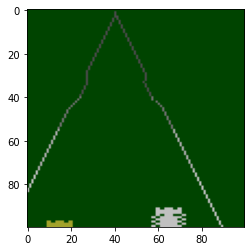

In [12]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [13]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 0.3998  0.8624 -0.8166 -0.8419 -0.9464  0.7499 -0.7123  1.3319 -0.091  -0.6963  0.546   0.0059
 -0.6956 -0.8752  0.1985 -0.3573 -0.4494  0.4228  1.7495 -0.2798 -1.3368  0.8347  2.0604  0.6958
  0.2004 -1.0092  0.7639 -0.0797 -0.3038 -1.4087 -0.9293  0.516  -0.8807  1.8457  0.6235  0.857
 -1.1839 -0.4489 -0.2864  1.4484  0.0763  0.5115  0.2528  0.1682 -0.3144  0.2399 -0.0941 -0.3063
 -1.3977 -1.2591  0.6418  0.2948 -0.2699  2.5386  0.9312  0.3943 -0.4087 -1.6918  0.2658 -0.1551
  0.0565 -1.3462 -0.4357 -1.1204], shape=(64,), dtype=float32)


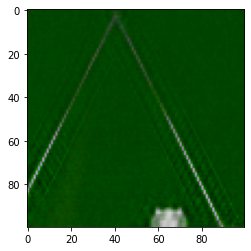

In [14]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

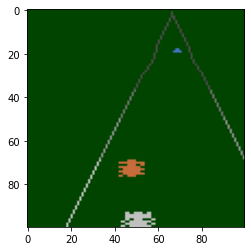

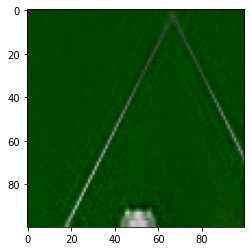

In [50]:
# need reshape to convert 64x64x3 into 1x64x64x3
frame = random.choice(obs).reshape(1, 100, 100, 3)
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()
batch_z = vae.encode(frame)
reconstruct = vae.decode(batch_z)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Sample the VAE

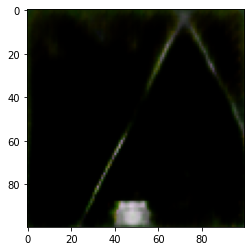

In [20]:
np.random.seed(65)
sample = np.random.rand(64).reshape(-1, 64)
reconstruct = vae.decode(sample)
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

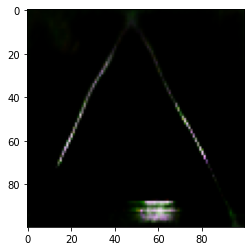

In [40]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()